Introduction 
===

In this notebook we will study the different discrete approximations of curvatures in an idealised capillary rise experiment modelled using the Young-Laplace equation. The idealised geometry of the problem allows for a more exact study of numerical errors by comparisons to the solution from the predefined geometry:

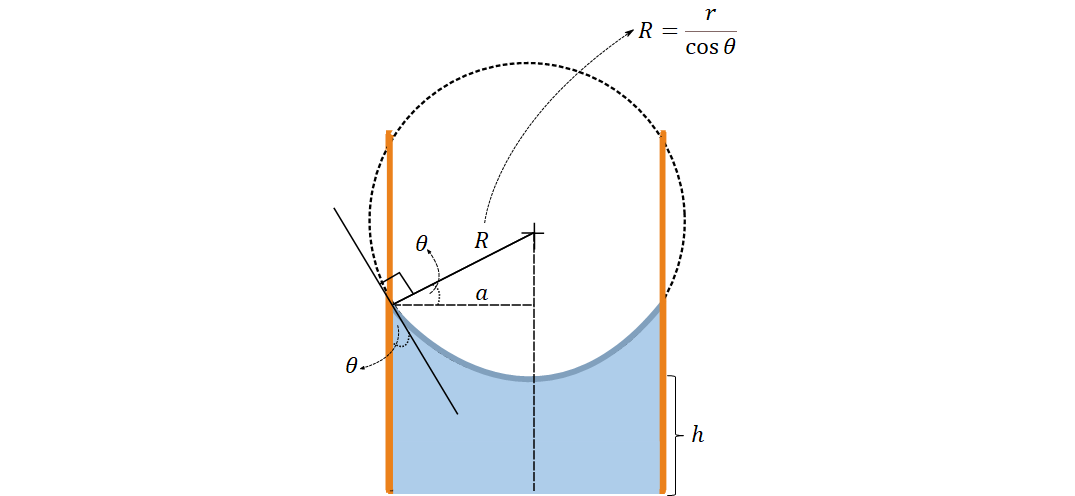


The Young-Laplace has an exact analytical solution $\Delta p$, related to the radius of the oscullating circle $R$:

$$
\Delta p=-\gamma H_{f}=-\gamma\left(\frac{1}{R_{1}}+\frac{1}{R_{2}}\right)=\frac{2 \gamma}{R}
$$


The purpose of this study is thus to find discretised approximiations of $H_{f} = \frac{2}{R}$ in order to provide insights into how we can compute numerical accuracies when simulating non-ideal systems. We use the following nomenclature and conventions throughout (from the course notes of Keenan Crane (https://brickisland.net/DDGSpring2020) (CC 4.0))


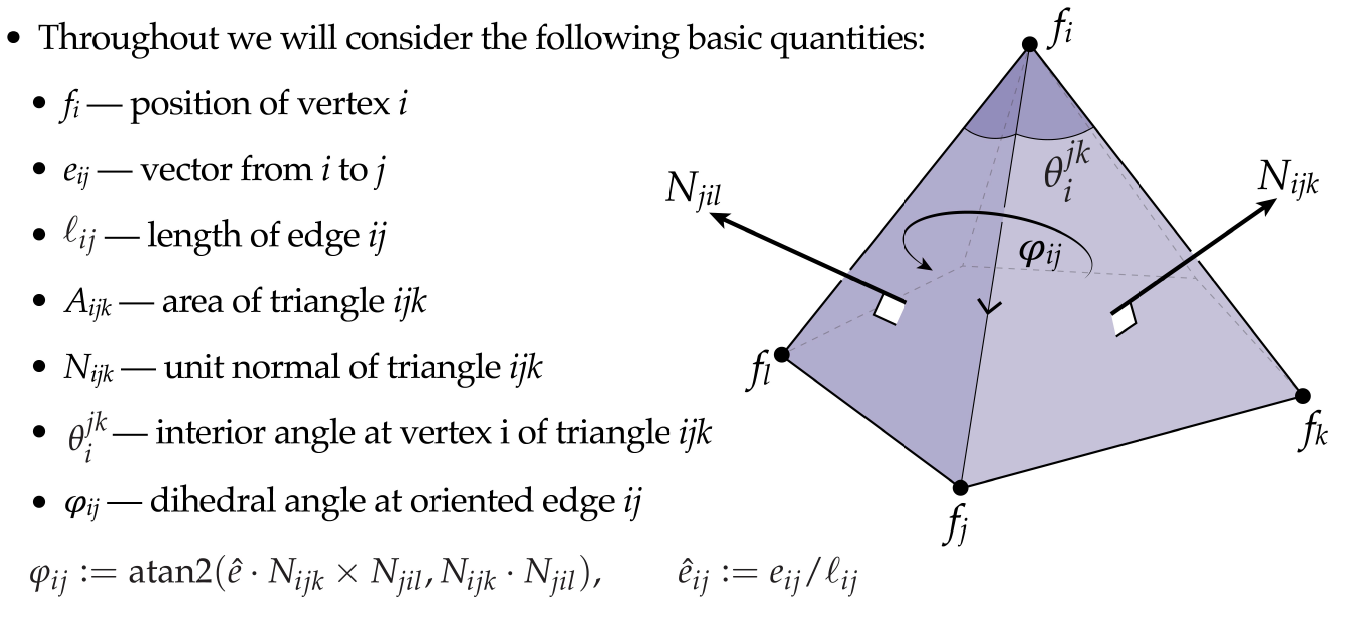

From the same notes the following overview of all discrete approximations and their relation to the smooth curvature definitions is also provided:

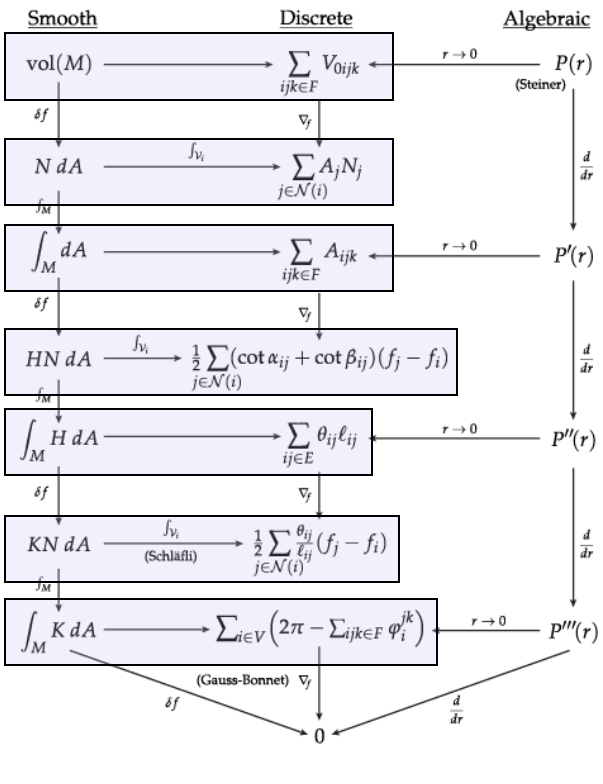


### We consider the following definitions for *vector curvatures*:

Gaussian normal curvature: $$\mathrm{KNdA} = \frac{1}{2} \sum_{i j \in \mathrm{St}(i)} \frac{\varphi_{i j}}{\ell_{i j}}\left(f_{j}-f_{i}\right)$$
Mean normal curvature: $$H N dA = \frac{1}{2} \sum_{i j \in \mathrm{St}(i)}\left(\cot \alpha_{i j}+\cot \beta_{i j}\right)\left(f_{i}-f_{j}\right)$$
Area: $$N d A = \frac{1}{6} \sum_{i j k \in \mathrm{St}(i)} f_{j} \times f_{k}$$
Volume: (No Hodge dual in $\mathbb{R}^3$; scalar values only)


### ...and the following definitions for *scalar curvatures*:

Gaussian curvature (angle defect): $$ \Omega_{i}:=2 \pi-\sum_{i j k} \theta_{i}^{j k}$$
Mean curvature: $$H_{i j}:=\frac{1}{2} \ell_{i j} \varphi_{i j}$$
Area: $$A_{i j k}$$
Volume: $$V_{i j k}$$

### The Gaussian and mean curvatures are related to each other through the principle curvatures:

Gaussian: $K=\kappa_{1} \kappa_{2}$

Mean: $H=\frac{\kappa_{1}+\kappa_{2}}{2}$

Since we know that $\kappa_{1} = \kappa_{2} $ we have $K=\kappa_{1}^2$ so 

$$
H=\frac{\sqrt{K}+\sqrt{K}}{2}
$$

The principle curvatures in the smooth setting are defined by:

$$
\begin{array}{l}
\kappa_{1}=H-\sqrt{H^{2}-K} \\
\kappa_{2}=H+\sqrt{H^{2}-K}
\end{array}
$$

The discrete principle curvatures can be found from

$$\frac{H_{i}}{A_{i}} \pm \sqrt{\left(\frac{H_{i}}{A_{i}}\right)^{2}-\frac{K_{i}}{A_{i}}}$$

Where the vertex normal curvature $H_{i}:=\frac{1}{4} \sum_{i j \in E} \ell_{i j} \varphi_{i j}$ is normalized over the area of the dual cell $A_{i}:=\left|C_{i}\right|$:

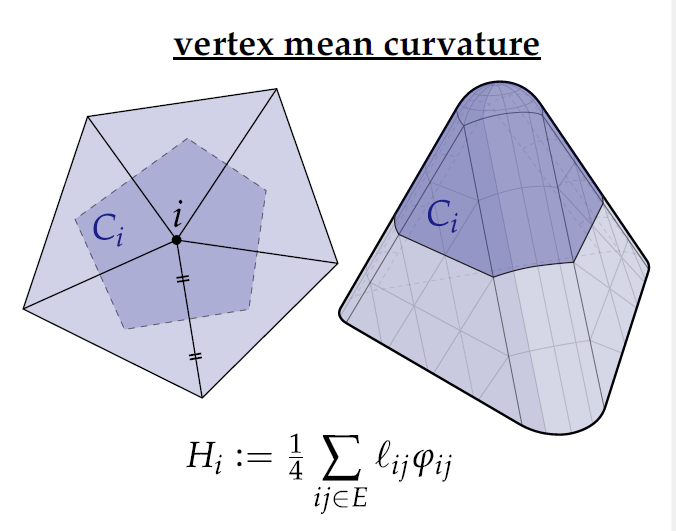

### ...finally the algebraic perpective allows us to compute curvatures from the Steiner polynomials (of a mollified surface):

$$
\text { volume }_{\varepsilon}(f)=V_{0}+\varepsilon \sum_{i j k \in F} A_{i j k}+\varepsilon^{2} \sum_{i j \in E} \ell_{i j} \varphi_{i j}+\varepsilon^{3} \sum_{i \in V} \Omega_{i}
$$

$$
\begin{array}{l}
\frac{d}{d \varepsilon} \text { volume }_{\varepsilon}=\text { area }_{\varepsilon} \\
\frac{d}{d \varepsilon} \text { area }_{\varepsilon}=\operatorname{mean}_{\varepsilon} \\
\frac{d}{d \varepsilon} \operatorname{mean}_{\varepsilon}=\text { Gauss }_{\varepsilon} \\
\frac{d}{d \varepsilon} \text { Gauss }_{\varepsilon}=0
\end{array}
$$

# Other notes:

#### Notes on the angle defect in the plane:

An equality that holds only when there is no curvature

$$2 \pi-\sum_{i} \theta_{i}=\frac{1}{6} \pi \varepsilon^{2} K$$

which was derived from the relation of ratios between spheres/balls of radius $\varepsilon$:

$$\frac{\varepsilon^{2}}{12} K \approx 1-\frac{\left|B_{g}(\varepsilon)\right|}{\left|B_{\mathbb{R}^{2}}(\varepsilon)\right|}$$

so that demonstrates how this equality is the integrated Gaussian curvature and this integral is the same for slight variations of $\varepsilon$. In the future we will study if it is possible to recover exact rations for different values of $\varepsilon$ by studying how exactly the area ratios vary. 

In the Extrinsic viewpoint the angle defect $\Omega$ becomes the integrated area on the unit sphere, the shaded are shown in this figure:


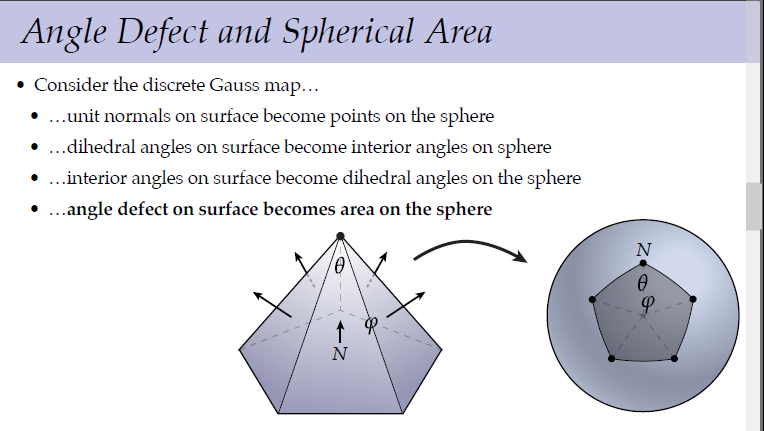



Discrete Gauss Bonnet Theorem:

$$\sum_{i \in \mathrm{int} V} \Omega_{i}+\sum_{i \in \partial V} \kappa_{i}=2 \pi \chi$$

where the boundary vertices are
$$\kappa_{i}:=\pi-\sum_{i j k} \theta_{i}^{j k}$$



In [232]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider
%matplotlib notebook

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

from ddgclib import *
from hyperct import *
from ddgclib._curvatures import * #plot_surface#, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue

In [233]:
r = 1  # m, Radius of the capillary tube
theta_p = 20 * np.pi/180.0  # Three phase contact angle
R = r / np.cos(theta_p)  # = R at theta = 0

# Exact values:
if theta_p < 90 * np.pi /180:
    K_f = (1 / R)**2
    H_f = 1 / R + 1 / R  # 2 / R
else:
    K_f = (1 / R)**2
    H_f = -1 / R - 1 / R  # 2 / R
    
def droplet_half_init(R, N, phi):
    # Theta = np.linspace(0.0, 2*np.pi)  # range of theta
    # Phi = np.linspace(0.0, np.pi)  # range of phi
    def sphere(R, theta, phi):
        return R * np.cos(theta) * np.sin(phi), R * np.sin(theta) * np.sin(phi), R * np.cos(phi)

    Theta = np.linspace(0.0, 2*np.pi, N)  # range of theta
    Phi = [np.pi] + [phi,]*(N - 1)
    F = []
    nn = []
    ind = -1
    for theta, phi in zip(Theta, Phi):
        ind += 1
        # Define coordinates:
        x, y, z = sphere(R, theta, phi)
        F.append(np.array([x, y, z]))
        # Define connections:
        nn.append([])
        if ind > 0:
            nn[0].append(ind)
            nn[ind].append(0)
            nn[ind].append(ind - 1)
            nn[ind].append((ind + 1) % N)

    F = np.array(F)
    nn[1][1] = ind

    return F, nn  

In [234]:
def cap_rise_init_N(r, theta_p, gamma, N=4, refinement=0):
    Theta = np.linspace(0.0, 2*np.pi, N)  # range of theta
    R = r / np.cos(theta_p)  # = R at theta = 0
    # Exact values:
    K_f = (1 / R)**2
    H_f = 1 / R + 1 / R  # 2 / R
     
    dp_exact = gamma * (2/R)  # Pa      # Young-Laplace equation  dp = - gamma * H_f = - gamma * (1/R1 + 1/R2)
    F = []
    nn = []
    F.append(np.array([0.0, 0.0, R * np.sin(theta_p) - R]))
    nn.append([])
    ind = 0
    for theta in Theta:
        ind += 1
        # Define coordinates:
        #x, y, z = sphere(R, theta, phi)
        F.append(np.array([r*np.sin(theta), r*np.cos(theta), 0.0]))
        # Define connections:
        nn.append([])
        if ind > 0:
            nn[0].append(ind)
            nn[ind].append(0)
            nn[ind].append(ind - 1)
            nn[ind].append((ind + 1) % N)
            
    F = np.array(F)
    nn[1][1] = ind

    return F, nn, K_f, H_f

In [235]:
erange = []
Nmax = 21
for N in range(4, Nmax+1):
    phi = 2
    r = 1  # m, Radius of the capillary tube
    theta_p = 20 * np.pi/180.0  # Three phase contact angle
    R = r / np.cos(theta_p)  # = R at theta = 0
    theta_p = 0 * np.pi/180.0  # Three phase contact angle
    #droplet_half_init(R, N, phi)

    #F, nn =F, nn = droplet_half_init(R, N, phi)
    F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)

    a = F[-1] 
    b = F[-2] 
    erange.append(numpy.linalg.norm(a-b))

print(erange)

[1.7320508075688776, 1.4142135623730951, 1.1755705045849463, 1.0000000000000004, 0.8677674782351162, 0.7653668647301796, 0.6840402866513375, 0.6180339887498949, 0.563465113682859, 0.5176380902050418, 0.47863132857511603, 0.44504186791262884, 0.41582338163551924, 0.390180644032257, 0.3674990356331405, 0.3472963553338612, 0.3291891805614678, 0.31286893008046174]


<IPython.core.display.Javascript object>


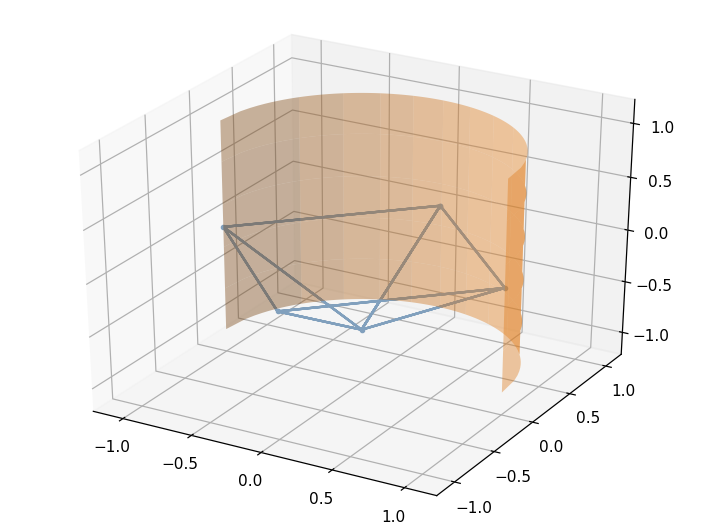

In [236]:
phi = 2
N = 5
r = 1  # m, Radius of the capillary tube
theta_p = 20 * np.pi/180.0  # Three phase contact angle
R = r / np.cos(theta_p)  # = R at theta = 0
theta_p = 20 * np.pi/180.0  # Three phase contact angle
#droplet_half_init(R, N, phi)

#F, nn =F, nn = droplet_half_init(R, N, phi)
F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
fig, axes, HC = plot_surface(F, nn)
axes.set_xlim3d(-(0.1*R + R) , 0.1*R + R)
axes.set_ylim3d(-(0.1*R + R) , 0.1*R + R)
axes.set_zlim3d(-(0.1*R + R) , 0.1*R + R)

# Cylinder
x=np.linspace(-r, r, 100)
z=np.linspace(-r, r, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(r**2-Xc**2)
rstride = 20
cstride = 10
axes.plot_surface(Xc, Yc, Zc, alpha=0.4, rstride=rstride, cstride=cstride, color=do)
#axes.plot_surface(Xc, -Yc, Zc, alpha=0.2, rstride=rstride, cstride=cstride)


In [280]:
bV = set()
for v in HC.V:
    if np.all(v.x_a[0:2] == 0.0):
        v_o = v  # origin vertex
        continue
    else:
        bV.add(v)

In [281]:
V = set(HC.V) - bV
for v in V:
    print(f'v.x = {v.x}')

v = HC.V[(0.0, 0.0, -1.0)]
FF, nn = vectorise_vnn(v)
FF, nn  

v.x = (0.0, 0.0, -0.7002075382097097)


(array([[ 0.,  0., -1.]]), [[]])

In [283]:
for v in bV:
    print(f'v.x = {v.x}')
    
F, nn, b_F, b_nn = b_vectorise_vnn(v)
F, nn, b_F, b_nn

v.x = (1.2246467991473532e-16, -1.0, 0.0)
v.x = (1.0, 6.123233995736766e-17, 0.0)
v.x = (-2.4492935982947064e-16, 1.0, 0.0)
v.x = (-1.0, -1.8369701987210297e-16, 0.0)
v.x = (0.0, 1.0, 0.0)
nn = [[1, 2, 3], [2, 3], [1], [1]]
nn_i = [1, 2, 3]
len(nn_i) = 3
nn_i = [2, 3]
len(nn_i) = 2
nn_i = [1]
len(nn_i) = 1
nn_i = [1]
len(nn_i) = 1


(array([[ 0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        , -0.70020754]]),
 [[1, 2, 3], [2, 3]],
 array([[ 1.0000000e+00,  6.1232340e-17,  0.0000000e+00],
        [-2.4492936e-16,  1.0000000e+00,  0.0000000e+00]]),
 [[1], [1]])

In [284]:
F

array([[ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        , -0.70020754]])

In [285]:
bE_ij = b_F - F[0]
# Discrete vector area (only two edges)
# Simplex areas of ijk and normals
wedge_ij_ik = np.cross(bE_ij[0], bE_ij[1])
bE_ij, wedge_ij_ik

(array([[ 1.0000000e+00, -1.0000000e+00,  0.0000000e+00],
        [-2.4492936e-16,  0.0000000e+00,  0.0000000e+00]]),
 array([-0.0000000e+00, -0.0000000e+00, -2.4492936e-16]))

In [286]:
theta_i_jk = np.arctan2(np.linalg.norm(wedge_ij_ik), np.dot(bE_ij[0], bE_ij[1]))
k_g = np.pi - theta_i_jk 
k_g

0.7853981633974483

In [290]:
@interact(r=(0.0,10.0,0.05), N=(3,20,1), theta_p=(0.0, 180, 5))
def update(r=0.5, N=5, theta_p=2):
    theta_p = theta_p * np.pi  /180.0
    try:
        axes.remove()
        fig.remove()
    except UnboundLocalError:
        pass

    F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
    fig, axes, HC = plot_surface(F, nn)
    axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
    axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
    axes.set_zlim3d(-(0.1*r + r) , 0.1*r + r)
    
    R = r / np.cos(theta_p)
    print(f'R = {R}')
    
    # Cylinder
    x=np.linspace(-r, r, 100)
    z=np.linspace(-r, r, 100)
    Xc, Zc = np.meshgrid(x, z)
    Yc = np.sqrt(r**2-Xc**2)
    rstride = 20
    cstride = 10
    axes.plot_surface(Xc, Yc, Zc, alpha=0.4, rstride=rstride, cstride=cstride, color=do)


interactive(children=(FloatSlider(value=0.5, description='r', max=10.0, step=0.05), IntSlider(value=5, descrip…

136.81924558642828

In [49]:
def out_plot_cap_rise(N=7, r=1, gamma=0.0728, refinement=0):
    Theta_p = np.linspace(0.0, np.pi, 100)  # range of theta
    
    # Containers
    H_i = []
    H_ij_sum = []
    K = []
    KNdA_ij_sum = []
    KNdA_ij_dot = []
    HNdA_ij_sum = []
    HNdA_ij_dot = []
    HdotNdA_ij_sum = []
    N_f0 = np.array([0.0, 0.0, -1])
    c_outd_list = []

    for theta_p in Theta_p:
        # Contruct the simplicial complex, plot the initial construction:
        #F, nn = droplet_half_init(R, N, phi)
        R = r / np.cos(theta_p)  # = R at theta = 0
        # Exact values:
        K_f = (1 / R) ** 2
        H_f = 1 / R + 1 / R  # 2 / R
        #dp_exact = gamma * H_f

        F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
        HC = construct_HC(F, nn)
        R = r / np.cos(theta_p)  # = R at theta = 0
        v = HC.V[(0.0, 0.0, R * np.sin(theta_p) - R)]
        F, nn = vectorise_vnn(v)

        # Compute discrete curvatures
        c_outd = curvatures(F, nn, n_i=N_f0)

        # Save results
        #c_outd = curvatures(F, nn)
        c_outd['K_f'] = K_f
        c_outd['H_f'] = H_f
        H_i.append(c_outd['H_i'])
        H_ij_sum.append(c_outd['H_ij_sum'])
        HNdA_ij_sum.append(np.sum(c_outd['HNdA_ij']))
        HNdA_ij_dot.append(np.sum(np.dot(c_outd['HNdA_ij'], c_outd['n_i'])))
        KNdA_ij_sum.append(np.sum(c_outd['KNdA_ij']))
        KNdA_ij_dot.append(np.sum(np.dot(c_outd['KNdA_ij'], c_outd['n_i'])))
        #HNdA_i.append()
        
        c_outd['HNdA_i']
        
        #print(f"HNdA_ij = {c_outd['HNdA_ij']}")
        #print(f" (np.dot(c_outd['HNdA_ij'], N_f0) = {np.dot(c_outd['HNdA_ij'], N_f0)}")
        HdotNdA_ij_sum.append(np.dot(c_outd['HNdA_ij'], N_f0))
        K.append(c_outd['K'])
        c_outd_list.append(c_outd)

    A_ijk = []
    C_ijk = []
    z = []
    
    for c_outd in c_outd_list:
        A_ijk.append(np.sum(c_outd['A_ijk']))
        C_ijk.append(np.sum(c_outd['C_ijk']))
        # Compute z:
        if 0:
            theta = 0.0
            r = R / np.cos(theta)  # = R at theta = 0
            y = r - r*np.sin(theta)
            theta_z = np.arctan(y/R)
            z_phi = y / np.sin(theta_z)
            z.append(z_phi)

    A_ijk = np.array(A_ijk)
    C_ijk = np.array(C_ijk)
    K_f = []
    H_f = []
    
    for c_outd in c_outd_list:
        K_f.append(np.sum(c_outd['K_f']))
        H_f.append(np.sum(c_outd['H_f']))
        #HN_i.append(np.sum(c_outd['HN_i']))

    H_disc = (1 / 2.0) * np.array(HNdA_ij_sum) / C_ijk    
    K_H =  (H_disc/2.0)
    vdict = {'K_f': K_f,
             #'K': K,
             'K/C_ijk': K / C_ijk,
             ' 0.5 * KNdA_ij_sum / C_ijk': (1 / 2.0) * np.array(KNdA_ij_sum) / C_ijk,
             '- 0.5 * KNdA_ij_dot / C_ijk': -(1 / 2.0) * np.array(KNdA_ij_dot) / C_ijk,
             '((K/C_ijk)^0.5 + (K/C_ijk)^0.5)': (np.sqrt(K/C_ijk) + np.sqrt(K/C_ijk)) ,#/2.0,  
             'H_f': H_f,
             '2 * H_i/C_ijk = H_ij_sum/C_ijk': H_ij_sum/C_ijk,
             ' -(1 / 2.0) * HNdA_ij_dot/C_ijk': -(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk,
             '(1/2)*HNdA_ij_sum/C_ijk': (1 / 2.0) * np.array(HNdA_ij_sum) / C_ijk, # Exactly equal to  -(1 / 2.0) * HNdA_ij_dot/C_ijk
             'K_H':  K_H**2,
             'K_H 2':  K_H**2
             #' -(1 / 2.0) * HNdA_ij_dot/A_ijk': -(1 / 2.0) * np.array(HNdA_ij_dot)/A_ijk,
             #' -(1 / 2.0) * HNdA_ij_dot/C_ijk / H_f': (-(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk)/np.array(H_f),
             #' (-(1 / 2.0) * HNdA_ij_dot/C_ijk)/r**2': r* ((-(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk)/r**2),
            # ' (-(1 / 2.0) * HNdA_ij_dot/C_ijk)/r**2/H_f': ((-(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk)/r**2)/np.array(H_f)
             }
    X = Theta_p * 180 / np.pi


    return c_outd_list, c_outd, vdict, X

In [50]:
#out_plot_cap_rise(N=7, R=0.5, r=1, theta_p=20.0, gamma=0.0728, refinement=0)

<IPython.core.display.Javascript object>


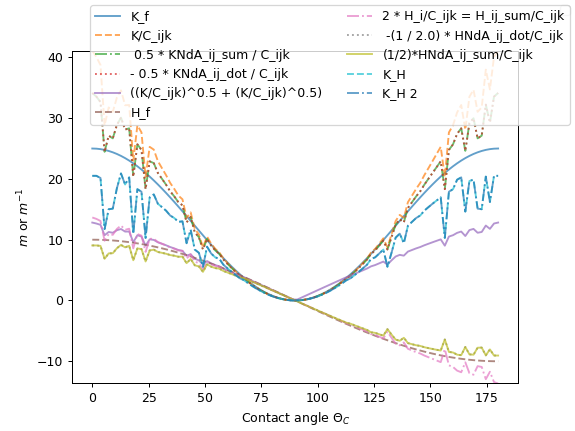

interactive(children=(FloatSlider(value=1.0, description='r', max=10.0, step=0.05), IntSlider(value=5, descrip…

In [51]:
##### %matplotlib notebook

R=0.5
N=7
c_outd_list, c_outd, vdict, X = out_plot_cap_rise(N=7, r=r)
#plot_variables(X, vdict, xlabel=r'Contact angle $\phi$')

fig = plt.figure()
#ax = fig.add_subplot(2, 1, 1)
ax = fig.add_subplot(1, 1, 1)

lstyles = ['-', '--', '-.', ':']
mod = len(lstyles)
ind = 0
Lines = {}
fig.legend()
for key, value in vdict.items():
    line, = ax.plot(X, value, linestyle=lstyles[ind], label=key, alpha=0.7)
    Lines[key] = line
    #plot.plot(X, value, linestyle=lstyles[ind], label=key, alpha=0.7)
    ind += 1
    ind = ind % mod
     
@interact(r=(0.0,10.0,0.05), N=(3,20,1))
def update(r=1.0, N=5):
    c_outd_list, c_outd, vdict, X = out_plot_cap_rise(N=N, r=r)
    #H_f = 1 / R + 1 / R
    #K_f = (1 / R) ** 2
    ind = 0
    maxy = 0.0
    miny = 0.0
    for key, value in vdict.items():
        Lines[key].set_xdata(X)
        Lines[key].set_ydata(value)
        ind += 1
        ind = ind % mod
        maxy = max(maxy, np.max(value))
        miny = min(miny, np.min(value))
        
    fig.canvas.draw_idle()
    ax.set_ylim(miny, maxy)  

plot.xlabel(r'Contact angle $\Theta_{C}$')
plot.ylabel(r'$m$ or $m^{-1}$')
#fig.legend(bbox_to_anchor=(1, 0.5), loc='right', ncol=2)
fig.legend(ncol=2)
#interact(update);

In [52]:
vdict.keys()


dict_keys(['K_f', 'K/C_ijk', ' 0.5 * KNdA_ij_sum / C_ijk', '- 0.5 * KNdA_ij_dot / C_ijk', '((K/C_ijk)^0.5 + (K/C_ijk)^0.5)', 'H_f', '2 * H_i/C_ijk = H_ij_sum/C_ijk', ' -(1 / 2.0) * HNdA_ij_dot/C_ijk', '(1/2)*HNdA_ij_sum/C_ijk', 'K_H', 'K_H 2'])

In [22]:
mathdict = {'K_f':r'K_f', 
'K/C_ijk', 
 ' 0.5 * KNdA_ij_sum / C_ijk',
 '- 0.5 * KNdA_ij_dot / C_ijk',
 '((K/C_ijk)^0.5 + (K/C_ijk)^0.5)',
 'H_f', '2 * H_i/C_ijk = H_ij_sum/C_ijk',
 ' -(1 / 2.0) * HNdA_ij_dot/C_ijk', 
 '-(1/2)*HNdA_ij_sum/C_ijk'
 }

SyntaxError: invalid syntax (<ipython-input-22-97d23c6531a1>, line 2)

<IPython.core.display.Javascript object>


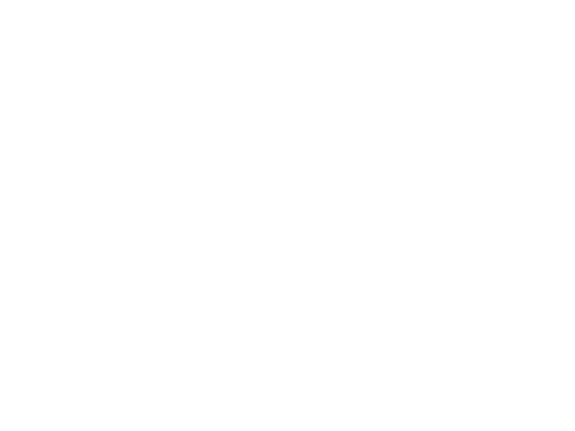

<IPython.core.display.Javascript object>


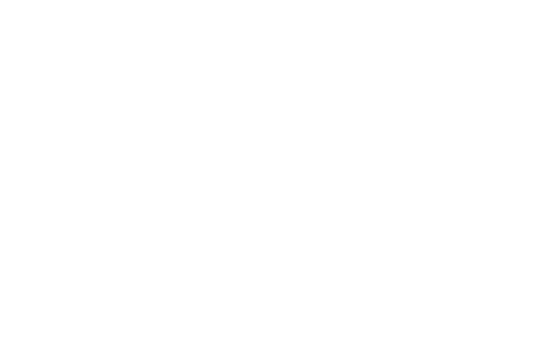

In [23]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
%matplotlib notebook

t = np.linspace(0.0, 1.0, 100)
s = np.cos(4 * np.pi * t) + 2

plt.figure()

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(t, s)

ax.set_xlabel(r'\textbf{time (s)}')
ax.set_ylabel('\\textit{Velocity (\N{DEGREE SIGN}/sec)}', fontsize=16)
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')
plt.show()

Gauss Bonnet
==

<IPython.core.display.Javascript object>


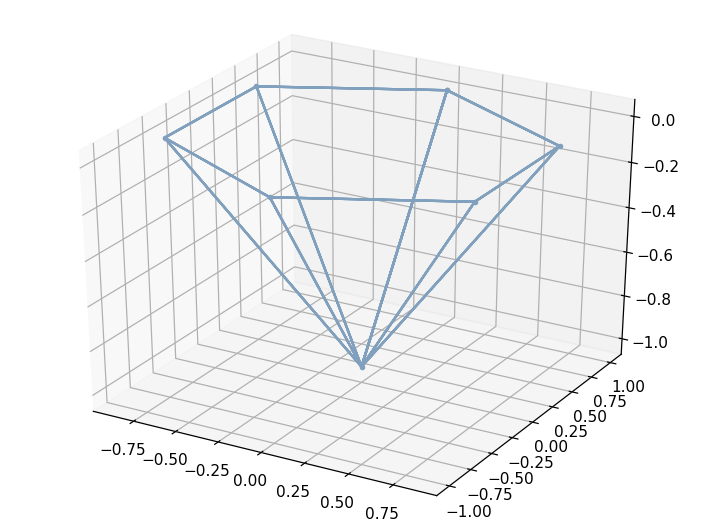

In [291]:
phi = 2
N = 7
r = 1  # m, Radius of the capillary tube
theta_p = 20 * np.pi/180.0  # Three phase contact angle
R = r / np.cos(theta)  # = R at theta = 0
theta_p = 0 * np.pi/180.0  # Three phase contact angle
F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
#F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
HC = construct_HC(F, nn)
fig, axes, HC = plot_surface(F, nn)

# boundary vertices are all on z=0:
bV = set()
for v in HC.V:
    if v.x[2] == 0.0:
        bV.add(v)
        

In [27]:
def chi_H(HC, print_out=False):
    """
    Compute the 2D Euler Characterisitc
    """
    ## Computer Euler Characteristic:
    # Compute the number of vertices
    V = len(list(HC.V))
    # Compute the dges
    E = 0
    for v in HC.V:
        E += len(list(v.nn))
        
    E = E/2.0 # We have added precisely twice the number of edges through adding each connection
    # Compute the faces
    HC.dim = 2  # We have taken the boundary of the sphere
    HC.vertex_face_mesh()
    Faces = HC.simplices_fm
    F = len(Faces)
    
    # Compute Euler
    chi = V - E + F
    if print_out:
        print(f'V = {V}')
        print(f'E = {E}')
        print(f'F = {F}')
        print(f'$\chi = V - E + F$ = {chi}')   
        
    return chi

def K_t(HC, bV=set()):
    """
    Compute the integrated Gaussian curvature on the surface 
    """
    KdA = 0.0
    for v in HC.V:
        if v in bV:
            continue
        else:
            N_f0 = v.x_a - np.zeros_like(v.x_a)  # First approximation # TODO: CHANGE FOR CAP RISE!
            F, nn = vectorise_vnn(v)
            # Compute discrete curvatures
            c_outd = curvatures(F, nn, n_i=N_f0)
            KdA += c_outd['Omega_i']  # == c_outd['K']
            
    return KdA
    
def k_g_t(HC, bV):
    k_g = 0
    for v in bV:
        Theta_i_jk = 0.0
        Simplices = set()
        Dual = set()
        for vn in v.nn:
            if vn in Dual:
                continue
            for vnn in vn.nn:
                if vnn in v.nn:  # Add edges connected to v_i
                    E_ij = vn.x_a - v.x_a
                    E_ik = vnn.x_a - v.x_a
                    
                    # Discrete vector area:
                    # Simplex areas of ijk and normals
                    wedge_ij_ik = np.cross(E_ij, E_ik)

                    #Wedge_ij_ik[j] = wedge_ij_ik
                    theta_i_jk = np.arctan2(np.linalg.norm(wedge_ij_ik), np.dot(E_ij, E_ik))
                    Theta_i_jk += theta_i_jk
                    Dual.add(vnn)

        k_g += np.pi - Theta_i_jk
        
    return k_g

def Gauss_Bonnet(HC, bV=set(), print_out=False):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    chi = chi_H(HC)
    KdA = K_t(HC, bV)
    k_g = k_g_t(HC, bV)
    if print_out:
        print(f' KdA = {KdA}')
        print(f' k_g = {k_g}')
        print(f' 2 pi chi$ = {2 * np.pi * chi}')
        print(f' LHS - RHS = {KdA + k_g - 2 * np.pi * chi}')
    return chi, KdA, k_g

Gauss_Bonnet(HC, bV, print_out=1)

NameError: name 'HC' is not defined

In [91]:
def out_plot_cap_rise_boundary(N=7, r=1, gamma=0.0728, refinement=0):
    Theta_p = np.linspace(0.0, np.pi, 100)  # range of theta
    
    # Containers
    H_i = []
    H_ij_sum = []
    K = []
    KNdA_ij_sum = []
    KNdA_ij_dot = []
    HNdA_ij_sum = []
    HNdA_ij_dot = []
    HdotNdA_ij_sum = []
    N_f0 = np.array([0.0, 0.0, -1])
    c_outd_list = []

    for theta_p in Theta_p:
        # Contruct the simplicial complex, plot the initial construction:
        #F, nn = droplet_half_init(R, N, phi)
        R = r / np.cos(theta_p)  # = R at theta = 0
        # Exact values:
        K_f = (1 / R) ** 2
        H_f = 1 / R + 1 / R  # 2 / R
        #dp_exact = gamma * H_f

        F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
        HC = construct_HC(F, nn)
        R = r / np.cos(theta_p)  # = R at theta = 0
        v = HC.V[(0.0, 0.0, R * np.sin(theta_p) - R)]
        F, nn = vectorise_vnn(v)
        
        # boundary vertices are all on z=0:
        bV = set()
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

        # Compute discrete curvatures
        c_outd = curvatures(F, nn, n_i=N_f0)
        
        # Compute boundary curvatures and Gauss_Bonnet
        chi, KdA, k_g = Gauss_Bonnet(HC, bV, print_out=False)

        # Save results
        #c_outd = curvatures(F, nn)
        c_outd['K_f'] = K_f
        c_outd['H_f'] = H_f
        H_i.append(c_outd['H_i'])
        H_ij_sum.append(c_outd['H_ij_sum'])
        HNdA_ij_sum.append(np.sum(c_outd['HNdA_ij']))
        HNdA_ij_dot.append(np.sum(np.dot(c_outd['HNdA_ij'], c_outd['n_i'])))
        KNdA_ij_sum.append(np.sum(c_outd['KNdA_ij']))
        KNdA_ij_dot.append(np.sum(np.dot(c_outd['KNdA_ij'], c_outd['n_i'])))
        #HNdA_i.append()
        
        c_outd['HNdA_i']
        
        c_outd['chi'] = chi
        c_outd['KdA'] = KdA
        c_outd['k_g'] = k_g
        
        #print(f"HNdA_ij = {c_outd['HNdA_ij']}")
        #print(f" (np.dot(c_outd['HNdA_ij'], N_f0) = {np.dot(c_outd['HNdA_ij'], N_f0)}")
        HdotNdA_ij_sum.append(np.dot(c_outd['HNdA_ij'], N_f0))
        K.append(c_outd['K'])
        c_outd_list.append(c_outd)

    A_ijk = []
    C_ijk = []
    z = []
    chi = []
    KdA = []
    k_g = []
    
    for c_outd in c_outd_list:
        A_ijk.append(np.sum(c_outd['A_ijk']))
        C_ijk.append(np.sum(c_outd['C_ijk']))
        chi.append(c_outd['chi'])
        KdA.append(c_outd['KdA'])
        k_g.append(c_outd['k_g'])
        # Compute z:
        if 0:
            theta = 0.0
            r = R / np.cos(theta)  # = R at theta = 0
            y = r - r*np.sin(theta)
            theta_z = np.arctan(y/R)
            z_phi = y / np.sin(theta_z)
            z.append(z_phi)

    A_ijk = np.array(A_ijk)
    C_ijk = np.array(C_ijk)
    K_f = []
    H_f = []
    
    for c_outd in c_outd_list:
        K_f.append(np.sum(c_outd['K_f']))
        H_f.append(np.sum(c_outd['H_f']))
        #HN_i.append(np.sum(c_outd['HN_i']))

    vdict = {'chi': np.array(chi) /np.pi,
             'KdA': np.array(KdA)/np.pi,
             'k_g': np.array(k_g)/np.pi,
             #'k_g aprrox':np.array(KdA) / ( np.arccos(1.0) * N**2),
             'KdA aprrox':np.arccos(1.0) * N**2 * np.array(k_g),
             '2 pi chi - KdA - k_g': np.array(2 * np.pi * np.array(chi) - KdA - k_g)/np.pi,
             #'K': K,  # Equal to KdA
             'K_f': np.array(K_f)/np.pi,
             'K/C_ijk': np.array(K / C_ijk)/np.pi,
            # ' 0.5 * KNdA_ij_sum / C_ijk': (1 / 2.0) * np.array(KNdA_ij_sum) / C_ijk,
            # '- 0.5 * KNdA_ij_dot / C_ijk': -(1 / 2.0) * np.array(KNdA_ij_dot) / C_ijk,
             #'((K/C_ijk)^0.5 + (K/C_ijk)^0.5)': (np.sqrt(K/C_ijk) + np.sqrt(K/C_ijk)) ,#/2.0,  
             #'H_f': H_f,
             #'2 * H_i/C_ijk = H_ij_sum/C_ijk': H_ij_sum/C_ijk,
             #' -(1 / 2.0) * HNdA_ij_dot/C_ijk': -(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk,
             #'-(1/2)*HNdA_ij_sum/C_ijk': (1 / 2.0) * np.array(HNdA_ij_sum) / C_ijk, # Exactly equal to  -(1 / 2.0) * HNdA_ij_dot/C_ijk
             #' -(1 / 2.0) * HNdA_ij_dot/A_ijk': -(1 / 2.0) * np.array(HNdA_ij_dot)/A_ijk,
             #' -(1 / 2.0) * HNdA_ij_dot/C_ijk / H_f': (-(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk)/np.array(H_f),
             #' (-(1 / 2.0) * HNdA_ij_dot/C_ijk)/r**2': r* ((-(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk)/r**2),
            # ' (-(1 / 2.0) * HNdA_ij_dot/C_ijk)/r**2/H_f': ((-(1 / 2.0) * np.array(HNdA_ij_dot)/C_ijk)/r**2)/np.array(H_f)
             }
    X = Theta_p * 180 / np.pi


    return c_outd_list, c_outd, vdict, X

In [29]:
##### 
R=0.5
N=7
c_outd_list, c_outd, vdict, X = out_plot_cap_rise_boundary(N=7, r=r)
#plot_variables(X, vdict, xlabel=r'Contact angle $\phi$')

fig = plt.figure()
#ax = fig.add_subplot(2, 1, 1)
ax = fig.add_subplot(1, 1, 1)

lstyles = ['-', '--', '-.', ':']
mod = len(lstyles)
ind = 0
Lines = {}
fig.legend()
for key, value in vdict.items():
    line, = ax.plot(X, value, linestyle=lstyles[ind], label=key, alpha=0.7)
    Lines[key] = line
    #plot.plot(X, value, linestyle=lstyles[ind], label=key, alpha=0.7)
    ind += 1
    ind = ind % mod
     
@interact(r=(0.0,10.0,0.05), N=(3,20,1))
def update(r=1.0, N=5):
    c_outd_list, c_outd, vdict, X = out_plot_cap_rise_boundary(N=N, r=r)
    #H_f = 1 / R + 1 / R
    #K_f = (1 / R) ** 2
    ind = 0
    maxy = 0.0
    miny = 0.0
    for key, value in vdict.items():
        Lines[key].set_xdata(X)
        Lines[key].set_ydata(value)
        ind += 1
        ind = ind % mod
        maxy = max(maxy, np.max(value))
        miny = min(miny, np.min(value))
        
    fig.canvas.draw_idle()
    ax.set_ylim(miny, maxy)  

plot.xlabel(r'Contact angle $\phi$')
plot.ylabel(r'$\pi \cdot  m$ or $\pi \cdot m^{-1}$')
#fig.legend(bbox_to_anchor=(1, 0.5), loc='right', ncol=2)
fig.legend(ncol=2)
#interact(update);

NameError: name 'construct_HC' is not defined

In [329]:
def out_plot_cap_rise_boundary(N=7, r=1, gamma=0.0728, refinement=0):
    Theta_p = np.linspace(0.0, np.pi, 100)  # range of theta
    
    # Containers
    H_i = []
    H_ij_sum = []
    K = []
    KNdA_ij_sum = []
    KNdA_ij_dot = []
    HNdA_ij_sum = []
    HNdA_ij_dot = []
    HdotNdA_ij_sum = []
    N_f0 = np.array([0.0, 0.0, -1])
    c_outd_list = []

    for theta_p in Theta_p:
        # Contruct the simplicial complex, plot the initial construction:
        #F, nn = droplet_half_init(R, N, phi)
        R = r / np.cos(theta_p)  # = R at theta = 0
        # Exact values:
        K_f = (1 / R) ** 2
        H_f = 1 / R + 1 / R  # 2 / R
        #dp_exact = gamma * H_f

        F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
        HC = construct_HC(F, nn)
        R = r / np.cos(theta_p)  # = R at theta = 0
        v = HC.V[(0.0, 0.0, R * np.sin(theta_p) - R)]
        F, nn = vectorise_vnn(v)
        
        # boundary vertices are all on z=0:
        bV = set()
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

        # Compute discrete curvatures
        c_outd = curvatures(F, nn, n_i=N_f0)
        
        # Compute boundary curvatures and Gauss_Bonnet
        chi, KdA, k_g = Gauss_Bonnet(HC, bV, print_out=False)

        # Save results
        #c_outd = curvatures(F, nn)
        c_outd['K_f'] = K_f
        c_outd['H_f'] = H_f
        H_i.append(c_outd['H_i'])
        H_ij_sum.append(c_outd['H_ij_sum'])
        HNdA_ij_sum.append(np.sum(c_outd['HNdA_ij']))
        HNdA_ij_dot.append(np.sum(np.dot(c_outd['HNdA_ij'], c_outd['n_i'])))
        KNdA_ij_sum.append(np.sum(c_outd['KNdA_ij']))
        KNdA_ij_dot.append(np.sum(np.dot(c_outd['KNdA_ij'], c_outd['n_i'])))
        #HNdA_i.append()
        
        c_outd['HNdA_i']
        
        c_outd['chi'] = chi
        c_outd['KdA'] = KdA
        c_outd['k_g'] = k_g
        
        #print(f"HNdA_ij = {c_outd['HNdA_ij']}")
        #print(f" (np.dot(c_outd['HNdA_ij'], N_f0) = {np.dot(c_outd['HNdA_ij'], N_f0)}")
        HdotNdA_ij_sum.append(np.dot(c_outd['HNdA_ij'], N_f0))
        K.append(c_outd['K'])
        c_outd_list.append(c_outd)

    A_ijk = []
    C_ijk = []
    z = []
    chi = []
    KdA = []
    k_g = []
    
    for c_outd in c_outd_list:
        A_ijk.append(np.sum(c_outd['A_ijk']))
        C_ijk.append(np.sum(c_outd['C_ijk']))
        chi.append(c_outd['chi'])
        KdA.append(c_outd['KdA'])
        k_g.append(c_outd['k_g'])
        # Compute z:
        if 0:
            theta = 0.0
            r = R / np.cos(theta)  # = R at theta = 0
            y = r - r*np.sin(theta)
            theta_z = np.arctan(y/R)
            z_phi = y / np.sin(theta_z)
            z.append(z_phi)

    A_ijk = np.array(A_ijk)
    C_ijk = np.array(C_ijk)
    K_f = []
    H_f = []
    
    for c_outd in c_outd_list:
        K_f.append(np.sum(c_outd['K_f']))
        H_f.append(np.sum(c_outd['H_f']))
        #HN_i.append(np.sum(c_outd['HN_i']))

        
    R = r / np.cos(Theta_p)  # = R at theta = 0
    vdict = {'chi': np.array(chi) /np.pi,
             #'k_g/KdA': np.array(k_g)/(np.array(KdA)),
             'KdA/k_g': np.array(KdA)/(np.array(k_g)),
             #'np.sin(np.array(KdA)/(np.array(k_g)))': np.sin((np.array(KdA)/(np.array(k_g)))/(N-1)),
            # 'np.cos((np.array(KdA)/(np.array(k_g)))/(N-1))': np.cos((np.array(KdA)/(np.array(k_g)))/(N-1)),
            # 'np.cos((np.array(KdA)/(np.array(k_g)))/(N-1)**2)': np.cos((np.array(KdA)/(np.array(k_g)))/(N-1)**2),
            # 'np.cos((np.array(KdA)/(np.array(k_g)))/(N)**2)': np.cos((np.array(KdA)/(np.array(k_g)))/(N)**2),
           #  'np.cos((np.array(KdA)/(np.array(k_g)))/ C_ijk)': np.cos((np.array(KdA)/(np.array(k_g)))/ C_ijk),
           #  'np.cos((np.array(KdA)/ C_ijk)': np.cos(np.array(KdA)/ C_ijk),
       #      'np.array(KdA)/(np.array(k_g)) - np.cos(Theta_p) ': np.array(KdA)/(np.array(k_g)) - np.cos(Theta_p) ,
        #     'np.sqrt(KdA/k_g)':np.sqrt(np.array(KdA)/(np.array(k_g))),
        #     'np.sqrt(KdA/k_g)/N':np.sqrt(np.array(KdA)/(np.array(k_g)))/N,
        #     'np.sqrt(KdA/k_g)/np.sqrt(N-1)':np.sqrt(np.array(KdA)/(np.array(k_g)))/np.sqrt(N-1),
             #'np.sqrt(KdA/k_g)/(np.cos(Theta_p))**2':np.sqrt(np.array(KdA)/(np.array(k_g)))/(np.cos(Theta_p))**2,
        #     'np.sqrt(KdA/k_g)*(np.cos(Theta_p))**2':np.sqrt(np.array(KdA)/(np.array(k_g)))*(np.cos(Theta_p))**2,
             #'np.sqrt(KdA/k_g)/(np.sin(Theta_p))**2':np.sqrt(np.array(KdA)/(np.array(k_g)))/(np.sin(Theta_p))**2,
        #     'np.sqrt(KdA/k_g)*(np.sin(Theta_p))**2':np.sqrt(np.array(KdA)/(np.array(k_g)))*(np.sin(Theta_p))**2,
        #     'np.sin(Theta_p)': np.sin(Theta_p),
        #     'np.cos(Theta_p)': np.cos(Theta_p),
             #'(KdA/k_g)**2':(np.array(KdA)/(np.array(k_g)))**2,
             #'np.array(KdA)/(np.array(k_g))/ (N-1)': np.array(KdA)/(np.array(k_g))/ (N-1),
             #'np.array(KdA)/(np.array(k_g)) * N/(N-1)': np.array(KdA)/(np.array(k_g)) * N/(N-1),
             #'-np.sin(Theta_p)': np.sin(Theta_p),
            # '-(np.sin(Theta_p))/2.0  + 0.5':-(np.sin(Theta_p))/2.0  + 0.5,
            # '-(np.sin(Theta_p))/(r + r)  + (1/r + 1/r)':-(np.sin(Theta_p))/(r + r) +0.5, #+ (1/r + 1/r)
            #  'np.array(KdA)/(np.array(k_g))/((N-1)**2)': np.array(KdA)/(np.array(k_g))/ ((N)**2),
             # 'np.array(KdA)/(np.array(k_g))/(np.sqrt(N))': np.array(KdA)/(np.array(k_g))/ (np.sqrt(N)),
             }
    X = Theta_p * 180 / np.pi


    return c_outd_list, c_outd, vdict, X

<IPython.core.display.Javascript object>


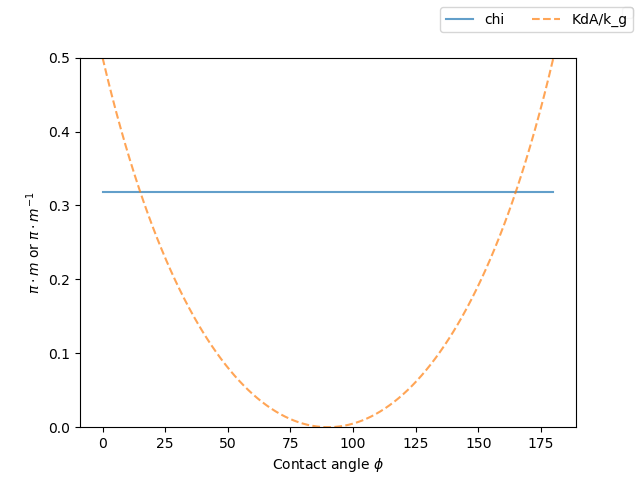

interactive(children=(FloatSlider(value=1.0, description='r', max=10.0, step=0.05), IntSlider(value=5, descrip…

In [330]:
##### 
R=0.5
N=7
c_outd_list, c_outd, vdict, X = out_plot_cap_rise_boundary(N=7, r=r)
#plot_variables(X, vdict, xlabel=r'Contact angle $\phi$')

fig = plt.figure()
#ax = fig.add_subplot(2, 1, 1)
ax = fig.add_subplot(1, 1, 1)

lstyles = ['-', '--', '-.', ':']
mod = len(lstyles)
ind = 0
Lines = {}
fig.legend()
for key, value in vdict.items():
    line, = ax.plot(X, value, linestyle=lstyles[ind], label=key, alpha=0.7)
    Lines[key] = line
    #plot.plot(X, value, linestyle=lstyles[ind], label=key, alpha=0.7)
    ind += 1
    ind = ind % mod
     
@interact(r=(0.0,10.0,0.05), N=(3,20,1))
def update(r=1.0, N=5):
    c_outd_list, c_outd, vdict, X = out_plot_cap_rise_boundary(N=N, r=r)
    print(f"vdict['KdA/k_g'] = {vdict['KdA/k_g']}")
    #print(f"vdict'np.cos((np.array(KdA)/ C_ijk)'] = {vdict['np.cos((np.array(KdA)/ C_ijk)']}")
    #print(f"'np.cos((np.array(KdA)/(np.array(k_g)))/(N-1))' = {vdict['np.cos((np.array(KdA)/(np.array(k_g)))/(N-1))']}")
    #print(f"'np.cos((np.array(KdA)/(np.array(k_g)))/(N-1)**2)' = {vdict['np.cos((np.array(KdA)/(np.array(k_g)))/(N-1)**2)']}")
    #print(f"'np.cos((np.array(KdA)/(np.array(k_g)))/(N)**2)' = {vdict['np.cos((np.array(KdA)/(np.array(k_g)))/(N)**2)']}")
  #  print(f"vdict['np.sqrt(KdA/k_g'] = {vdict['np.sqrt(KdA/k_g)']}")
  #  print(f"vdict['np.sqrt(KdA/k_g)/N'] = {vdict['np.sqrt(KdA/k_g)/N']}")
    #print(f"vdict['KdA/k_g'] = {vdict['KdA/k_g']/np.sin()}")
    #print(f"vdict['KdA/k_g']/(np.cos(Theta_p))**2 = {vdict['np.sqrt(KdA/k_g)/(np.cos(Theta_p))**2']}")
  #  print(f"vdict['KdA/k_g']*(np.cos(Theta_p))**2 = {vdict['np.sqrt(KdA/k_g)*(np.cos(Theta_p))**2']}")
  #  print(f"vdict['KdA/k_g']*(np.sin(Theta_p))**2 = {vdict['np.sqrt(KdA/k_g)*(np.sin(Theta_p))**2']}")
          #print(f"vdict['KdA/k_g'] = {vdict['np.sqrt(KdA/k_g)/(np.sin(Theta_p))**2']}")
    #print(f"'(KdA/k_g)**2' = {vdict['(KdA/k_g)**2']}")
    #print(f"vdict['KdA/k_g']/ (N-1) = {vdict['np.array(KdA)/(np.array(k_g))/ (N-1)']}")
    #print(f"np.array(KdA)/(np.array(k_g)) * N/(N-1) = {vdict['np.array(KdA)/(np.array(k_g)) * N/(N-1)']}")
          
    #H_f = 1 / R + 1 / R
    #K_f = (1 / R) ** 2
    ind = 0
    maxy = 0.0
    miny = 0.0
    for key, value in vdict.items():
        Lines[key].set_xdata(X)
        Lines[key].set_ydata(value)
        ind += 1
        ind = ind % mod
        maxy = max(maxy, np.max(value))
        miny = min(miny, np.min(value))
        
    fig.canvas.draw_idle()
    ax.set_ylim(miny, maxy)  

plot.xlabel(r'Contact angle $\phi$')
plot.ylabel(r'$\pi \cdot  m$ or $\pi \cdot m^{-1}$')
#fig.legend(bbox_to_anchor=(1, 0.5), loc='right', ncol=2)
fig.legend(ncol=2)
#interact(update);

In [ ]:
# np.cos((np.array(KdA)/(np.array(k_g)))/(N)**2) == 1.0
# np.array(KdA)/(np.array(k_g)) == np.arccos(1.0) * N**2
# np.array(KdA) == np.arccos(1.0) * N**2 * (np.array(k_g)
# k_g == np.array(KdA) / ( np.arccos(1.0) * N**2)






# np.array(KdA)/(np.array(k_g)) == np.arccos(1.0 * N**2)
# np.array(KdA) == np.arccos(1.0 * N**2) * (np.array(k_g))
#np.array(KdA)/ np.arccos(1.0 * N**2) ==  (np.array(k_g)
# np.array(k_g) == np.array(KdA)/ np.arccos(1.0 * N**2) 

In [ ]:
#np.cos((np.array(KdA)/(np.array(k_g)))/(N)**2)  == 1
# (np.array(KdA)/(np.array(k_g)))/(N)**2 = np.arccos(1.0)
# (np.array(KdA)/(np.array(k_g))) = np.arccos(1.0) * N**2
# np.array(KdA) = np.arccos(1.0) * N**2 * (np.array(k_g)
# np.array(KdA) = np.arccos(1.0) * N**2 * np.array(k_g)

In [109]:
def out_plot_cap_rise_boundary(N=7, r=1, gamma=0.0728, refinement=0):
    Theta_p = np.linspace(0.0, np.pi, 100)  # range of theta
    
    # Containers
    H_i = []
    H_ij_sum = []
    K = []
    KNdA_ij_sum = []
    KNdA_ij_dot = []
    HNdA_ij_sum = []
    HNdA_ij_dot = []
    HdotNdA_ij_sum = []
    N_f0 = np.array([0.0, 0.0, -1])
    c_outd_list = []

    for theta_p in Theta_p:
        # Contruct the simplicial complex, plot the initial construction:
        #F, nn = droplet_half_init(R, N, phi)
        R = r / np.cos(theta_p)  # = R at theta = 0
        # Exact values:
        K_f = (1 / R) ** 2
        H_f = 1 / R + 1 / R  # 2 / R
        #dp_exact = gamma * H_f

        F, nn, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=0)
        HC = construct_HC(F, nn)
        R = r / np.cos(theta_p)  # = R at theta = 0
        v = HC.V[(0.0, 0.0, R * np.sin(theta_p) - R)]
        F, nn = vectorise_vnn(v)
        
        # boundary vertices are all on z=0:
        bV = set()
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

        # Compute discrete curvatures
        c_outd = curvatures(F, nn, n_i=N_f0)
        
        # Compute boundary curvatures and Gauss_Bonnet
        chi, KdA, k_g = Gauss_Bonnet(HC, bV, print_out=False)

        # Save results
        #c_outd = curvatures(F, nn)
        c_outd['K_f'] = K_f
        c_outd['H_f'] = H_f
        H_i.append(c_outd['H_i'])
        H_ij_sum.append(c_outd['H_ij_sum'])
        HNdA_ij_sum.append(np.sum(c_outd['HNdA_ij']))
        HNdA_ij_dot.append(np.sum(np.dot(c_outd['HNdA_ij'], c_outd['n_i'])))
        KNdA_ij_sum.append(np.sum(c_outd['KNdA_ij']))
        KNdA_ij_dot.append(np.sum(np.dot(c_outd['KNdA_ij'], c_outd['n_i'])))
        #HNdA_i.append()
        
        c_outd['HNdA_i']
        
        c_outd['chi'] = chi
        c_outd['KdA'] = KdA
        c_outd['k_g'] = k_g
        
        #print(f"HNdA_ij = {c_outd['HNdA_ij']}")
        #print(f" (np.dot(c_outd['HNdA_ij'], N_f0) = {np.dot(c_outd['HNdA_ij'], N_f0)}")
        HdotNdA_ij_sum.append(np.dot(c_outd['HNdA_ij'], N_f0))
        K.append(c_outd['K'])
        c_outd_list.append(c_outd)

    A_ijk = []
    C_ijk = []
    z = []
    chi = []
    KdA = []
    k_g = []
    
    for c_outd in c_outd_list:
        A_ijk.append(np.sum(c_outd['A_ijk']))
        C_ijk.append(np.sum(c_outd['C_ijk']))
        chi.append(c_outd['chi'])
        KdA.append(c_outd['KdA'])
        k_g.append(c_outd['k_g'])
        # Compute z:
        if 0:
            theta = 0.0
            r = R / np.cos(theta)  # = R at theta = 0
            y = r - r*np.sin(theta)
            theta_z = np.arctan(y/R)
            z_phi = y / np.sin(theta_z)
            z.append(z_phi)

    A_ijk = np.array(A_ijk)
    C_ijk = np.array(C_ijk)
    K_f = []
    H_f = []
    
    for c_outd in c_outd_list:
        K_f.append(np.sum(c_outd['K_f']))
        H_f.append(np.sum(c_outd['H_f']))
        #HN_i.append(np.sum(c_outd['HN_i']))

    vdict = {'chi': chi,
             'KdA': KdA,
             'k_g': k_g,
             '2 pi chi - KdA - k_g': 2 * np.pi * np.array(chi) - KdA - k_g,
             'K_f': K_f,
             'K/C_ijk': K / C_ijk,
             }
    X = Theta_p * 180 / np.pi


    return c_outd_list, c_outd, vdict, X

Older code
====

---
---
---

In [147]:
HC.V.print_out()

Vertex cache of size: 6:
Vertex: (0.0, 0.0, -1.0)
Connections: (1.2246467991473532e-16, -1.0, 0.0) (1.0, 6.123233995736766e-17, 0.0) (-2.4492935982947064e-16, 1.0, 0.0) (-1.0, -1.8369701987210297e-16, 0.0) (0.0, 1.0, 0.0) 
Vertex: (0.0, 1.0, 0.0)
Connections: (0.0, 0.0, -1.0) (1.0, 6.123233995736766e-17, 0.0) (-2.4492935982947064e-16, 1.0, 0.0) 
Vertex: (1.0, 6.123233995736766e-17, 0.0)
Connections: (0.0, 0.0, -1.0) (0.0, 1.0, 0.0) (1.2246467991473532e-16, -1.0, 0.0) 
Vertex: (1.2246467991473532e-16, -1.0, 0.0)
Connections: (-1.0, -1.8369701987210297e-16, 0.0) (0.0, 0.0, -1.0) (1.0, 6.123233995736766e-17, 0.0) 
Vertex: (-1.0, -1.8369701987210297e-16, 0.0)
Connections: (0.0, 0.0, -1.0) (1.2246467991473532e-16, -1.0, 0.0) (-2.4492935982947064e-16, 1.0, 0.0) 
Vertex: (-2.4492935982947064e-16, 1.0, 0.0)
Connections: (-1.0, -1.8369701987210297e-16, 0.0) (0.0, 0.0, -1.0) (0.0, 1.0, 0.0) 


In [13]:
# Example calculation with the minimum discretisation
r = 1
THETA = np.linspace(0, 2*np.pi)
THETA = np.linspace(0, np.pi)
#theta = 20 *np.pi/180

H_i = []
H_ij_sum = []
K = []
K = []
K_f = []
H_f = []
HNdA_ij_sum = []
c_outd_list = []

for theta in THETA:
    # Compute discrete curvatures
    F, nn, K_f_theta, H_f_theta = cap_rise_init(r, theta, gamma, boundary_vertices=4, refinement=0)
    
    # Save results
    K_f.append(K_f_theta)
    H_f.append(H_f_theta)
    c_outd = curvatures(F, nn)
    c_outd['K_f'] = K_f
    c_outd['H_f'] = H_f
    H_i.append(c_outd['H_i'])
    H_ij_sum.append(c_outd['H_ij_sum'])
    HNdA_ij_sum.append(np.sum(c_outd['HNdA_ij']))
    K.append(c_outd['K'])    
    c_outd_list.append(c_outd)
"""
dict_keys(['F', 'nn', 'n_i', 'E_ij', 'E_jk', 'E_ik', 'hat_E_ij', 'L_ij', 'Varphi_ij',
'mdp_ij', 'mdp_ik', 'j_k', 'j_l', 'Theta_i_jk', 'Wedge_ij_ik', 'A_ijk', 'N_ijk', 'N_ijl', 
'C_ijk', 'KNdA_ij', 'HNdA_ij', 'NdA_ij', 'H_ij', 'V_ijk', 'i', 'j', 'k', 'l', 'wedge_ij_ik',
'a_ijk', 'n_ijk', 'wedge_ij_il', 'a_ijl', 'n_ijl', 'arg1', 'arg2', 'varphi_ij', 'c', 'a', 'b', 
'alpha_ij', 'beta_ij', 'theta_i_jk', 'A', 'v_dual', 'h_ij', 'b_ij', 'C_ij', 'h_ik', 'b_ik', 'C_ik', 
'KNdA_i', 'HNdA_i', 'HN_i', 'NdA_i', 'Omega_i', 'K', 'H_i', 'H_ij_sum', 'K_f', 'H_f'])
"""
H_i = np.array(H_i)
H_ij_sum = np.array(H_ij_sum)
# Exact hydrostatics
dp_exact = H_f_theta * gamma
X = THETA*180/np.pi
help(plot_variables)

Help on function plot_variables in module ddgclib._curvatures:

plot_variables(X, vdict, xlabel='Contact angle $\\theta$', ylabel='-')



<IPython.core.display.Javascript object>


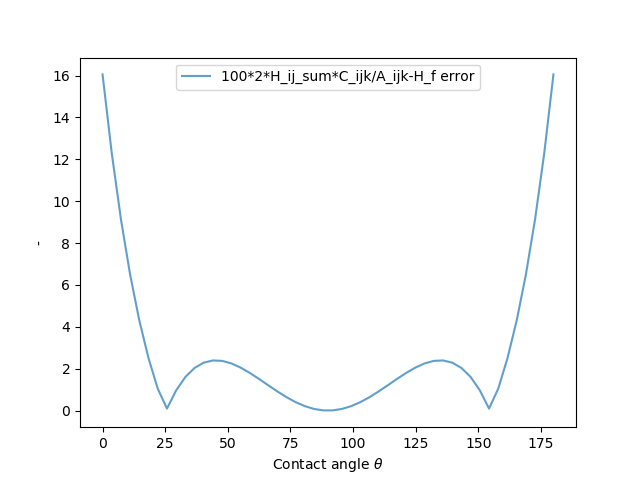

In [14]:
A_ijk = []
C_ijk = []
for c_outd in c_outd_list:
    A_ijk.append(np.sum(c_outd['A_ijk']))
    C_ijk.append(np.sum(c_outd['C_ijk']))
    
vdict = {'100*2*H_ij_sum*C_ijk/A_ijk-H_f error':100*abs(2*np.array(H_ij_sum)*np.array(C_ijk)/A_ijk-H_f)/H_f }
plot_variables(X, vdict)

In [15]:
# We will vary the contact angle theta and the tube radius r
def curvatures(F, nn):
    """
    F: Array of vectors forming the star domain of v_i = F[0]
    nn: Connections within each vertex in union with the star domain
    """
    # NOTE: We need a better solution to ensure signed quantities retain their structure.
    #      The mesh must be ordered to ensure we obtain the correct normal face directions
    n_i = normalized(F[0])[0]
    #print(f'n_i = {n_i}')
    # TODO: Later we can cache these containers to avoid extra computations
    # Edges from i to j:
    E_ij = F[1:] - F[0]
    E_ij = np.vstack([np.zeros(3), E_ij])
    E_jk = np.zeros_like(E_ij)
    E_ik = np.zeros_like(E_ij)
    #print(f'E_ij = {E_ij}')
    hat_E_ij = normalized(E_ij)
    # E_ij = e_ij
    L_ij = np.linalg.norm(E_ij, axis=1)
    #print(f'L_ij = {L_ij}')
    Varphi_ij = np.zeros_like(L_ij)

    # Edge midpoints
    mdp_ij = 0.5 * E_ij + F[0]  # = 0.5*E_ik + v_i
    # mdp_ik = 0.5*E_ik  + F[0]
    mdp_ik = np.zeros_like(E_ij)

    j_k = np.zeros_like(L_ij)  # Temporary index container for tests (usually not needed outside loop)
    j_l = np.zeros_like(L_ij)  # Temporary index container for tests (usually not needed outside loop)

    # Simplices ijk:
    # Indexed by i=0, j and k is determined by "the neighbour of `i` and `j` that is not `l` "
    Theta_i_jk = np.zeros_like(L_ij)
    Wedge_ij_ik = np.zeros_like(E_ij)
    A_ijk = np.zeros_like(L_ij)
    N_ijk = np.zeros_like(E_ij)
    N_ijl = np.zeros_like(E_ij)

    # Define midpoints
    C_ijk = np.zeros_like(A_ijk)

    # Vector curvature containers
    KNdA_ij = np.zeros_like(E_ij)  # Vector Gauss curvature normal sums
    HNdA_ij = np.zeros_like(E_ij)  # Vector mean curvature normal sums
    NdA_ij = np.zeros_like(E_ij)  # Area curvature normal sums

    # Scalar curvature containers
    H_ij = np.zeros_like(L_ij)  # Edge mean curvatures
    A_ijk = A_ijk  # Area
    C_ijk = np.zeros_like(A_ijk)  # Dual area
    V_ijk = np.zeros_like(A_ijk)  # Volume
    # A_ij = np.zeros_like(L_ij)   # Vector area ??

    i = 0
    # Note, every neighbour adds  precisely one simplex:
    for j in nn[0]:
        # Recover indices from nn (in code recover the vertex entry in the cache)
        k = nn[j][0]  # - 1
        l = nn[j][1]  # - 1

        # Discrete vector area:
        # Simplex areas of ijk and normals
        wedge_ij_ik = np.cross(E_ij[j], E_ij[k])
        if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
            k, l = l, k
            wedge_ij_ik = np.cross(E_ij[j], E_ij[k])

        # Save indexes (for testing)
        j_k[j] = k
        j_l[j] = l

        Wedge_ij_ik[j] = wedge_ij_ik
        # vector product of the parallelogram spanned by f_i and f_j is the triangle area
        a_ijk = np.linalg.norm(wedge_ij_ik) / 2
        A_ijk[j] = a_ijk
        n_ijk = wedge_ij_ik / np.linalg.norm(wedge_ij_ik)
        N_ijk[j] = n_ijk

        # Simplex areas of ijl and normals (TODO: RECPVER FROM A MINI IJK CACHE)
        wedge_ij_il = np.cross(E_ij[j], E_ij[l])
        a_ijl = np.linalg.norm(wedge_ij_il) / 2
        n_ijl = -wedge_ij_il / np.linalg.norm(wedge_ij_il)  # TODO: TEST THIS
        N_ijl[j] = n_ijl

        # Dihedral angle at oriented edge ij:
        arg1 = np.dot(hat_E_ij[j], np.cross(n_ijk, n_ijl))
        arg2 = np.dot(n_ijk, n_ijl)
        varphi_ij = np.arctan2(arg1, arg2)
        Varphi_ij[j] = varphi_ij  # NOTE: Signed value!

        # Interior angles: # Law of Cosines
        c = L_ij[j]  # l_ij
        a = np.linalg.norm(F[k] - F[i], axis=0)  # l_ik  # Symmetric to b
        b = np.linalg.norm(F[k] - F[l], axis=0)  # l_lk
        alpha_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))
        a = np.linalg.norm(F[k] - F[i], axis=0)  # l_il  # Symmetric to b
        b = np.linalg.norm(F[l] - F[j], axis=0)  # l_lj
        beta_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))

        ## Curvatures
        # Vector curvatures
        # Guassian normal curvature
        KNdA_ij[j] = (varphi_ij) / (L_ij[j]) * (F[j] - F[i])
        # Mean normal curvatre
        # Ratio of dual/primal length is given by cotan formula, yielding
        # HNdA_ij[j] = (cotan(alpha_ij) + cotan(beta_ij)) * (F[i] - F[j])
        HNdA_ij[j] = (cotan(alpha_ij) + cotan(beta_ij)) * (F[j] - F[i])
        #print(f'(cotan(alpha_ij) + cotan(beta_ij)) * (F[i] - F[j]) = {(cotan(alpha_ij) + cotan(beta_ij)) * (F[i] - F[j])}')
        # NdA_ij[j] = np.cross(F[i], F[j])
        # (^ NOTE: The above vertices i, j MUST be consecutive for this fomula to be valid (CHECK!))
        NdA_ij[j] = np.cross(F[j], F[k])
        # (^ NOTE: The above vertices j, k MUST be consecutive for this fomula to be valid (CHECK!))

        # Salar component ijk
        # Interior angle
        theta_i_jk = np.arctan2(np.linalg.norm(wedge_ij_ik), np.dot(E_ij[j], E_ij[k]))
        Theta_i_jk[j] = theta_i_jk
        # Mean normal
        H_ij[j] = L_ij[j] * varphi_ij

        # Areas
        E_jk[j] = F[k] - F[j]
        E_ik[j] = F[k] - F[i]
        # Solve the plane
        mdp_ik[j] = 0.5 * E_ik[j] + F[0]
        c = np.zeros(3)
        A = np.zeros([3, 3])
        A[0] = E_ij[j]
        A[1] = E_ik[j]
        A[2] = N_ijk[j]
        c[0] = np.dot(E_ij[j], mdp_ij[j])
        c[1] = np.dot(E_ik[j], mdp_ik[j])
        c[2] = np.dot(N_ijk[j], F[0])
        v_dual = np.linalg.solve(A, c)
        h_ij = np.linalg.norm(0.5 * L_ij[j])  # = 0.5*E_ik  + F[0] ?   = F[0] -(0.5*E_ik  + F[0]) = 0.5
        b_ij = np.linalg.norm(v_dual - mdp_ij[j])  # wrong
        C_ij = 0.5 * b_ij * h_ij

        # h_ik = np.linalg.norm(0.5*L_ij[int(j_k[j])])  # = 0.5*E_ik  + F[0] ?   = F[0] -(0.5*E_ik  + F[0]) = 0.5
        h_ik = np.linalg.norm(0.5 * L_ij[k])
        b_ik = np.linalg.norm(v_dual - mdp_ik[j])
        C_ik = 0.5 * b_ik * h_ik
        C_ijk[j] = C_ij + C_ik  # the area dual to A_ijk (validated at 90deg/0 curvature)

    pass
    N_ijk = np.array(N_ijk)
    N_ijl = np.array(N_ijl)
    Wedge_ij_ik = np.array(Wedge_ij_ik)
    KNdA_i = 0.5 * np.sum(KNdA_ij, axis=0)  # Vector Gauss curvature normal sums
    # (^ The integrated area of the unit sphere)
    HNdA_i = 0.5 * np.sum(HNdA_ij, axis=0)  # Vector mean curvature normal sums (multiplied by N?)
    # HN_i = 0.5 * np.sum(HN_ij, axis=0)
    HN_i = 0.5 * np.sum(H_ij, axis=0)
    NdA_i = (1 / 6.0) * np.sum(NdA_ij, axis=0)  # Vector normal  are sums
    # (^ The integrated area of the original smooth surface (a Dual discrete differential 2-form))
    # KN_i = 0.5 * np.sum(KN_ij, axis=0)  # Vector Gauss curvature normal sums ????

    ## Scalar curvatures of vertex i:
    # Gaussian curvature (angle defct)
    Omega_i = 2 * np.pi - np.sum(Theta_i_jk)
    K = Omega_i
    # Mean curvature
    H_i = (1 / 4.0) * np.sum(H_ij)
    H_ij_sum = (1 / 2.0) * np.sum(H_ij)

    # Area curvature:

    # Volume curvature

    ## Principle curvatures
    # Smooth approximated curvatures:
    # krms np.sqrt(H_i**2 - K)
    # kappa_1 = H - krms
    # kappa_2 = H - krms
    # A_i  # A_i := abs(C_i) the area of the dual cell
    return dict(**locals())

In [16]:
# H / (np.sqrt(np.array(z/r))) /r**2 

<IPython.core.display.Javascript object>


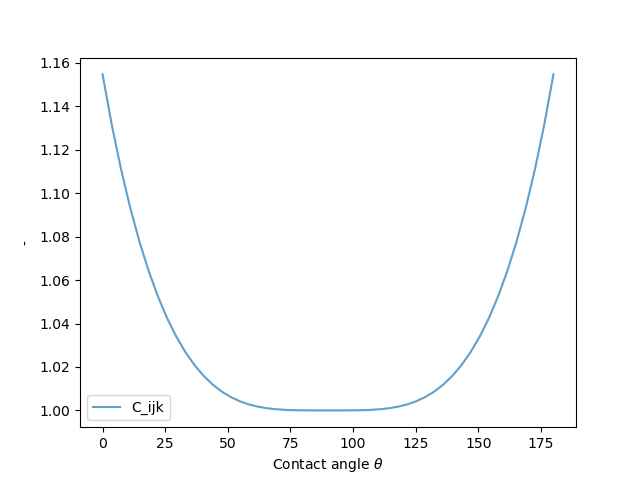

In [17]:
A_ijk = []
C_ijk = []
for c_outd in c_outd_list:
    A_ijk.append(np.sum(c_outd['A_ijk']))
    C_ijk.append(np.sum(c_outd['C_ijk']))
    
#vdict = {'100*2*H_ij_sum*C_ijk/A_ijk-H_f error':100*abs(2*np.array(H_ij_sum)*np.array(C_ijk)/A_ijk-H_f)/H_f }
vdict = {#'A_ijk/C_ijk': np.array(A_ijk)/C_ijk,
         'C_ijk': C_ijk
        }
plot_variables(X, vdict)

In [18]:
np.array(A_ijk)/C_ijk, C_ijk/np.array(A_ijk)

(array([3.        , 2.93592978, 2.87212284, 2.80884137, 2.74634542,
        2.68489178, 2.624733  , 2.56611626, 2.50928245, 2.4544651 ,
        2.40188947, 2.3517716 , 2.30431745, 2.259722  , 2.21816852,
        2.17982775, 2.14485724, 2.11340069, 2.08558738, 2.06153158,
        2.04133215, 2.02507209, 2.01281822, 2.00462089, 2.00051378,
        2.00051378, 2.00462089, 2.01281822, 2.02507209, 2.04133215,
        2.06153158, 2.08558738, 2.11340069, 2.14485724, 2.17982775,
        2.21816852, 2.259722  , 2.30431745, 2.3517716 , 2.40188947,
        2.4544651 , 2.50928245, 2.56611626, 2.624733  , 2.68489178,
        2.74634542, 2.80884137, 2.87212284, 2.93592978, 3.        ]),
 array([0.33333333, 0.3406076 , 0.34817452, 0.35601868, 0.36412026,
        0.37245449, 0.38099113, 0.38969396, 0.3985203 , 0.40742075,
        0.41633889, 0.42521136, 0.43396798, 0.44253231, 0.45082238,
        0.45875185, 0.4662315 , 0.47317104, 0.47948123, 0.48507625,
        0.48987618, 0.49380958, 0.49681585, 0.

<IPython.core.display.Javascript object>


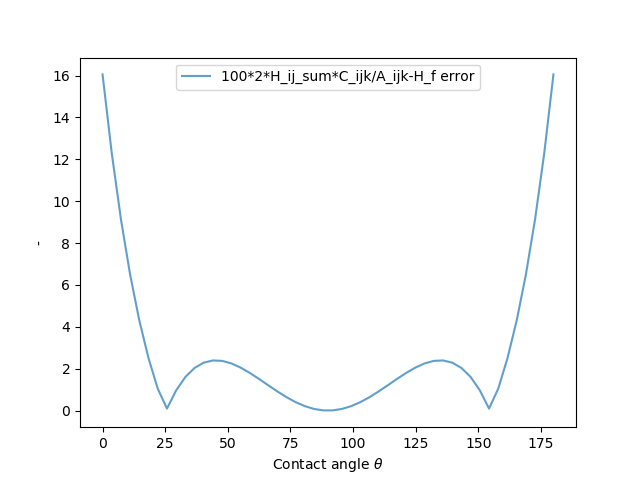

In [19]:
A_ijk = []
C_ijk = []
for c_outd in c_outd_list:
    A_ijk.append(np.sum(c_outd['A_ijk']))
    C_ijk.append(np.sum(c_outd['C_ijk']))
    
vdict = {'100*2*H_ij_sum*C_ijk/A_ijk-H_f error':100*abs(2*np.array(H_ij_sum)*np.array(C_ijk)/A_ijk-H_f)/H_f }
plot_variables(X, vdict)

<IPython.core.display.Javascript object>


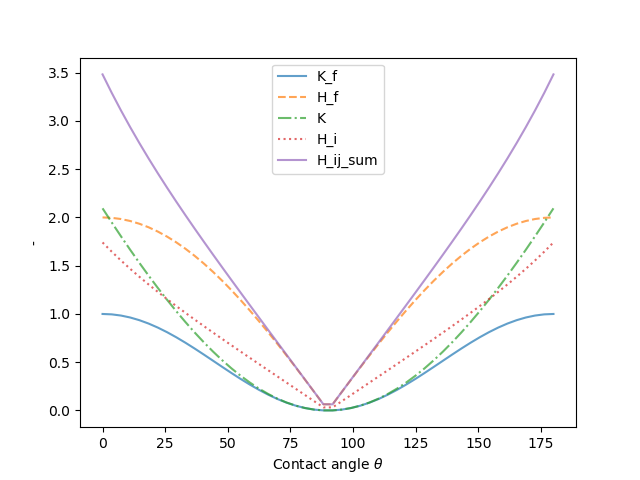

In [20]:
vdict = {'K_f': K_f,
         'H_f': H_f,
         'K': K,
         'H_i': H_i,
         'H_ij_sum': H_ij_sum
         }
plot_variables(X, vdict, xlabel=r'Contact angle $\theta$')

<IPython.core.display.Javascript object>


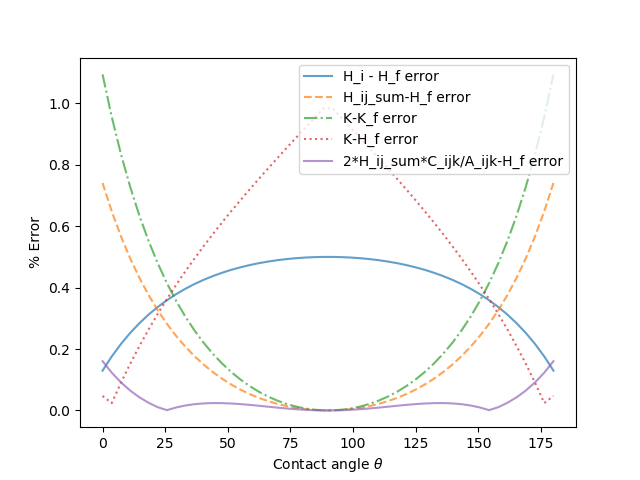

In [21]:
vdict = {'H_i - H_f error': abs(np.array(H_i) - H_f)/H_f,
         'H_ij_sum-H_f error': abs(np.array(H_ij_sum) - H_f)/H_f,
         'K-K_f error': abs(np.array(K)-K_f)/K_f,
         'K-H_f error': abs(np.array(K)-H_f)/H_f,
         '2*H_ij_sum*C_ijk/A_ijk-H_f error': abs(2*np.array(H_ij_sum)*np.array(C_ijk)/A_ijk-H_f)/H_f
         }
plot_variables(X, vdict, xlabel=r'Contact angle $\theta$', ylabel=r'% Error')

<IPython.core.display.Javascript object>


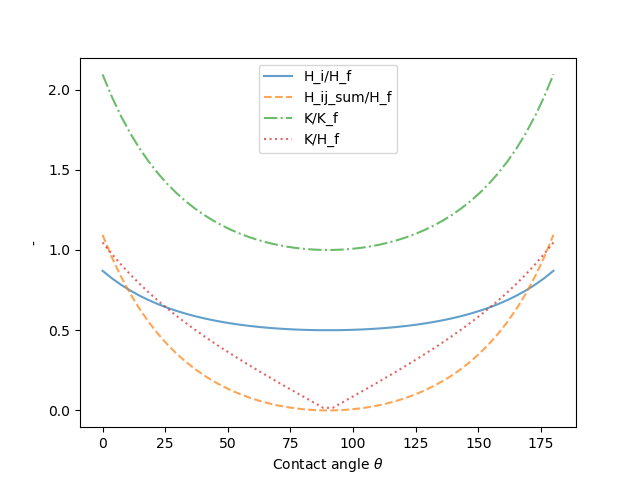

In [22]:
vdict = {'H_i/H_f': np.array(H_i)/H_f,
         'H_ij_sum/H_f': np.array(H_ij_sum)/H_f,
         'H_ij_sum/H_f': abs(np.array(K)-K_f)/K_f,
         'K/K_f': np.array(K)/K_f,
         'K/H_f': np.array(K)/H_f
         }
plot_variables(X, vdict, xlabel=r'Contact angle $\theta$', ylabel='-')

<IPython.core.display.Javascript object>


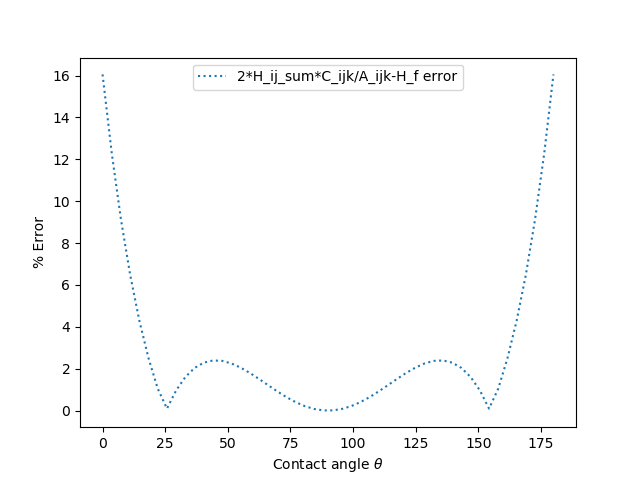

In [23]:
plot.figure()
plot.plot(THETA*180/np.pi, 100*abs(2*np.array(H_ij_sum)*np.array(C_ijk)/A_ijk-H_f)/H_f, linestyle=':', label='2*H_ij_sum*C_ijk/A_ijk-H_f error')
plot.xlabel(r'Contact angle $\theta$')
plot.ylabel(r'% Error')
plot.legend()

<IPython.core.display.Javascript object>


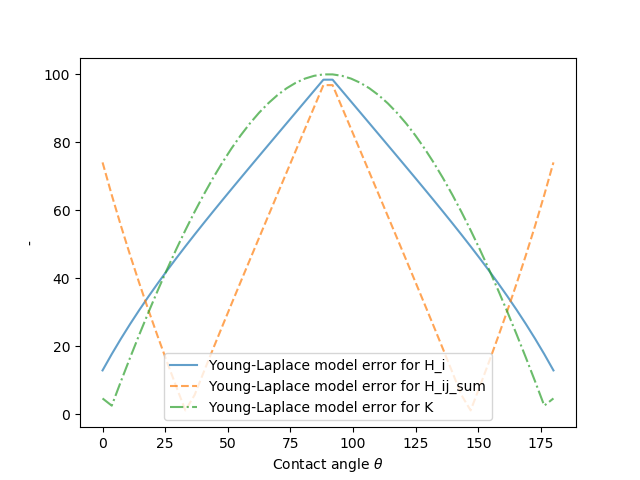

In [24]:
vdict = {'Young-Laplace model error for H_i': abs(gamma*H_i - dp_exact)/dp_exact *100,
         'Young-Laplace model error for H_ij_sum': abs(gamma*H_ij_sum - dp_exact)/dp_exact *100,
         'Young-Laplace model error for K': abs(gamma*np.array(K) - dp_exact)/dp_exact *100,
         }
plot_variables(X, vdict, xlabel=r'Contact angle $\theta$')

Previous
===

In [25]:
100*abs(2*np.array(H_ij_sum)*np.array(C_ijk)/A_ijk-H_f)/H_f

array([1.60559668e+01, 1.22950058e+01, 9.13117512e+00, 6.48571629e+00,
       4.29265090e+00, 2.49601920e+00, 1.04772087e+00, 9.41885635e-02,
       9.66850811e-01, 1.60368200e+00, 2.03522727e+00, 2.28982995e+00,
       2.39414127e+00, 2.37348854e+00, 2.25211430e+00, 2.05329629e+00,
       1.79935718e+00, 1.51157400e+00, 1.20999972e+00, 9.13212935e-01,
       6.38015308e-01, 3.99100434e-01, 2.08720059e-01, 7.63747898e-02,
       8.55514491e-03, 8.55514491e-03, 7.63747898e-02, 2.08720059e-01,
       3.99100434e-01, 6.38015308e-01, 9.13212935e-01, 1.20999972e+00,
       1.51157400e+00, 1.79935718e+00, 2.05329629e+00, 2.25211430e+00,
       2.37348854e+00, 2.39414127e+00, 2.28982995e+00, 2.03522727e+00,
       1.60368200e+00, 9.66850811e-01, 9.41885635e-02, 1.04772087e+00,
       2.49601920e+00, 4.29265090e+00, 6.48571629e+00, 9.13117512e+00,
       1.22950058e+01, 1.60559668e+01])

<IPython.core.display.Javascript object>


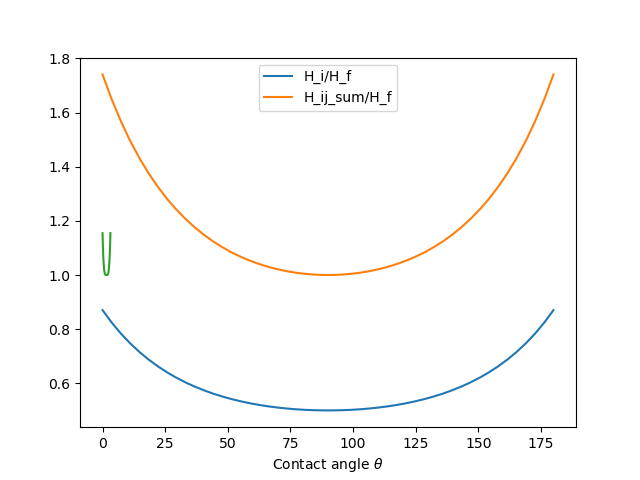

In [26]:
plot.figure()
plot.plot(THETA*180/np.pi, np.array(H_i)/H_f, label='H_i/H_f')
plot.plot(THETA*180/np.pi, np.array(H_ij_sum)/H_f, label='H_ij_sum/H_f')
#plot.plot(THETA*180/np.pi, np.array(HNdA_ij_sum)/H_f, label='HNdA_ij_sum')
plot.xlabel(r'Contact angle $\theta$')
plot.legend()

In [27]:
THETA = np.linspace(0, np.pi)  # (radian, angle from 0 to 180 deg)
#THETA = np.linspace(0, np.pi/4.0)  # (radian, angle from 0 to 180 deg)
Hlist = []
Hn_list = []
Area_list = []
Area_rec_list = []
pij_list = []
lap_j_list = []
R_list = []
z_list = []
for theta in THETA:
    r = 1  # 1 mm radius of tube
    R = r / np.cos(theta)  # = R at theta = 0
    R_list.append(R)
    H_f = 1/R + 1/R
    dp_exact = 2 * gamma / R # Pa      # Young-Laplace equation  dp = - gamma * H_f = - gamma * (1/R1 + 1/R2)
    # Jurin's law
    h = 2 * gamma * np.cos(theta) / (rho * g * r)
    
    # Let the reference vertex have a function value of zero
    y = R - R*np.sin(theta)#/2  This is the height of the boundary contact above the meniscus in m

    alpha_j = np.pi/4  # 45 degrees (square)
    beta_j = np.pi/4  # 45 degrees (square)
    # Area of rectangle plane (from pathagorean theorom)
    Area_rec = (np.sqrt(r**2 + r**2))**2  # edge = np.sqrt(R**2 + R**2)
    Area_rec_list.append(Area_rec)
    Area_plane = Area_rec
    
    """NOTE: BAD CLOSE TO theta 0.0, GOOD CLOSE TO theta 90.0"""
    # Compute the area of a theta =/= 0 surface using Heron's formula
    # Note that the area above is only true with our octahedron approximation
    y = R - R*np.sin(theta)#/2  This is the height of the boundary contact above the meniscus in m
       
    theta_z = np.arctan(y/r)
    z = y / np.sin(theta_z)
    z_list.append(z)
            
    pij = y #z  # = p_j - p_i
    pij_list.append(pij)
    a, b = z, z 
    c = np.sqrt(r**2 + r**2)
    s = (a + b + c)/2
    #Area_triangle = np.sqrt(s*(s - a)*(s - b)*(s - c)) /2
    Area_triangle = np.sqrt(s*(s - a)*(s - b)*(s - c))
    Area_rec = Area_triangle * 4    # 4 in triangles in the lower triangulation
    #Area_rec = Area_rec#*2
    d = (-a**2 + b**2 + c**2)/(2*c)
    h = np.sqrt(b**2 - d**2)
    alpha_j = np.arcsin(h/z)
    beta_j = alpha_j 
    """"""

    Area_list.append(Area_rec)
    # Cotan forumla:
    lap_j = ((cotan(alpha_j) + cotan(beta_j)) * -pij)
    lap_j_list.append(lap_j)
    H = 0.5 * (4 * lap_j)  # Mean cuvature change at bottom vertex
   # H = 0.0
    #Hn = H / Area_rec  # Normalize the curvature to the to area of the vertex star domain
    #Hn = H #/ (Area_rec/Area_plane)#**(1/R)
    #Hn =   H / Area_plane # """NOTE: GOOD CLOSE TO theta 0.0"""
    #Hn =  0.5* H / Area_plane * (Area_rec/Area_plane) # """NOTE: GOOD CLOSE TO theta 90.0"""
    #Hn =   H / Area_plane * (Area_rec/Area_plane) # Same result as using plane alpha_beta
    #Hn =   H / np.sin(theta_z) / Area_plane
    #Hn =   H / (np.sqrt(np.array(z)))  # Normalize to vector?
    Hn =   H / (np.sqrt(np.array(z/r))) /r**2 # Normalize to vector?
    Hlist.append(-H/H_f)
    Hn_list.append(-Hn/H_f)
    print(f'Error % at theta= {theta * 180.0 / np.pi} deg =  abs(dp - dp_exact)/dp_exact*100 = {abs(-Hn * gamma - dp_exact)/dp_exact *100}')
    print(f' alpha_j = {alpha_j} vs {np.pi/4}')
    #print(f'H = {H}')
    
from matplotlib import pyplot as plot
#plot.plot(THETA, Flist)
Area_list = np.array(Area_list)
Hlist = np.array(Hlist)
#plot.plot(THETA, np.array(Area_list))
plot.plot(THETA, np.array(Hlist))
Hlist

Error % at theta= 0.0 deg =  abs(dp - dp_exact)/dp_exact*100 = 2.9016456585352204
 alpha_j = 1.0471975511965974 vs 0.7853981633974483
Error % at theta= 3.6734693877551017 deg =  abs(dp - dp_exact)/dp_exact*100 = 3.35996190538082
 alpha_j = 1.0288914387450183 vs 0.7853981633974483
Error % at theta= 7.346938775510203 deg =  abs(dp - dp_exact)/dp_exact*100 = 3.704600142551174
 alpha_j = 1.0110068652520396 vs 0.7853981633974483
Error % at theta= 11.020408163265305 deg =  abs(dp - dp_exact)/dp_exact*100 = 3.9457711161397078
 alpha_j = 0.9935708213257688 vs 0.7853981633974483
Error % at theta= 14.693877551020407 deg =  abs(dp - dp_exact)/dp_exact*100 = 4.092969583460944
 alpha_j = 0.9766113746356369 vs 0.7853981633974483
Error % at theta= 18.36734693877551 deg =  abs(dp - dp_exact)/dp_exact*100 = 4.155161254656696
 alpha_j = 0.9601576428856465 vs 0.7853981633974483
Error % at theta= 22.04081632653061 deg =  abs(dp - dp_exact)/dp_exact*100 = 4.140937898729787
 alpha_j = 0.9442397464603687 vs 

array([1.15470054, 1.13154549, 1.11121371, 1.09340634, 1.07786277,
       1.06435341, 1.05267405, 1.04264115, 1.0340881 , 1.02686218,
       1.02082214, 1.0158363 , 1.01178111, 1.00854011, 1.00600332,
       1.00406693, 1.00263332, 1.00161135, 1.00091691, 1.0004736 ,
       1.00021361, 1.00007859, 1.00002054, 1.00000267, 1.00000003,
       1.00000003, 1.00000267, 1.00002054, 1.00007859, 1.00021361,
       1.0004736 , 1.00091691, 1.00161135, 1.00263332, 1.00406693,
       1.00600332, 1.00854011, 1.01178111, 1.0158363 , 1.02082214,
       1.02686218, 1.0340881 , 1.04264115, 1.05267405, 1.06435341,
       1.07786277, 1.09340634, 1.11121371, 1.13154549, 1.15470054])

In [28]:
4*10*1.1**35

1124.097473922573

In [29]:
65-30

35

<IPython.core.display.Javascript object>


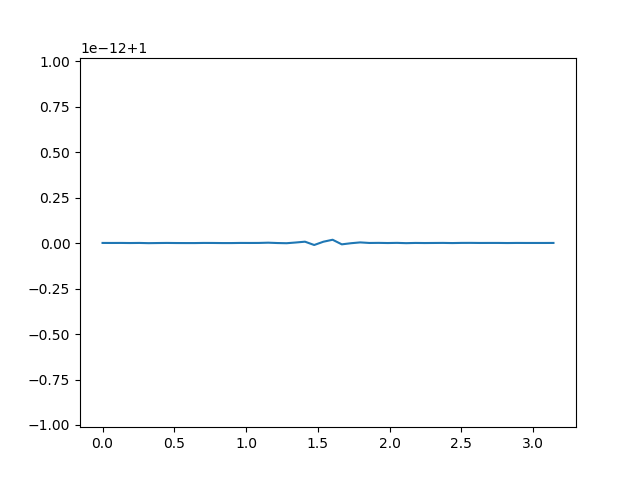

In [30]:
plot.figure()
plot.plot(THETA, np.array(Hlist)/C_ijk)

In [31]:
H

2.3094010767585047